# Import Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay
from mlflow.sklearn import autolog

# Load the Data

In [2]:
# read the csv file

df = pd.read_csv("tested.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# check for missing values in data

(
    df
    .isna()
    .sum()
)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

**Observations**:
1. `Age`, `Emabrked` and `Cabin` columns have missing values.

In [4]:
# info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


# Data CLeaning

In [78]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Fare'].fillna(df['Fare'].mode()[0], inplace=True)

/var/folders/30/0njqs3l10dnf4dblhpx1rqg80000gn/T/ipykernel_25907/4275527447.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
/var/folders/30/0njqs3l10dnf4dblhpx1rqg80000gn/T/ipykernel_25907/4275527447.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [79]:
# columns to drop

columns_to_drop = ['passengerid','name','ticket','cabin']

In [80]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family = lambda df_ : df_['sibsp'] + df_['parch']
        )
        .drop(columns=['sibsp','parch'])
    )

In [81]:
final_df = clean_data(df)

final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,34.5,7.8292,Q,0
1,1,3,female,47.0,7.0000,S,1
2,0,2,male,62.0,9.6875,Q,0
3,0,3,male,27.0,8.6625,S,0
4,1,3,female,22.0,12.2875,S,2


In [82]:
# shape of the cleaned data 

print(f'The cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The cleaned data has 418 rows and 7 columns


In [83]:
# missing values in the cleaned data

(
    final_df
    .isna()
    .sum()
)

survived    0
pclass      0
sex         0
age         0
fare        0
embarked    0
family      0
dtype: int64

# EDA

In [84]:
# distribution of target

(
    final_df
    .loc[:,'survived']
    .value_counts(normalize=True)
)

survived
0    0.636364
1    0.363636
Name: proportion, dtype: float64

In [85]:
# boxplots

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

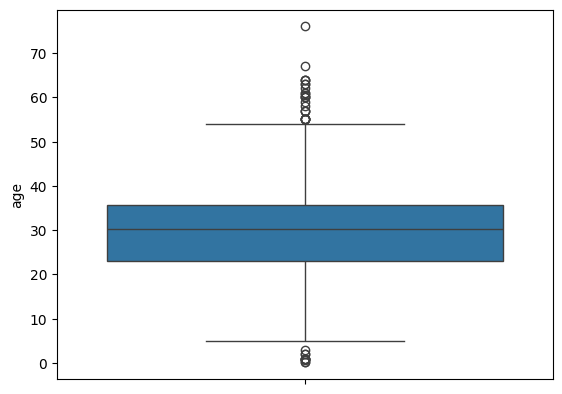

In [86]:
# boxplot for age column
create_boxplot(final_df,'age')

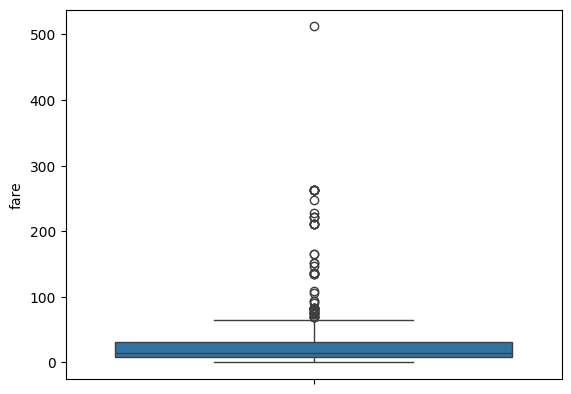

In [87]:
# boxplot for fare column

create_boxplot(final_df,'fare')

**Overview**
- Outliers in the age and fare columns

In [88]:
# plot the distribution of categorical columns

def plot_distribution(data,column_name):
    sns.countplot(data=data, x=column_name)

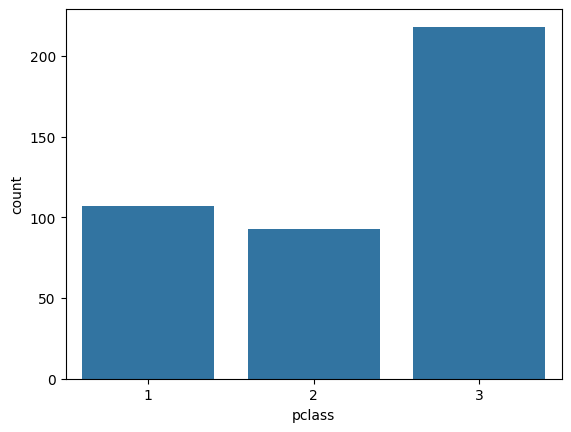

In [89]:
# distribution for pclass
plot_distribution(final_df,'pclass')

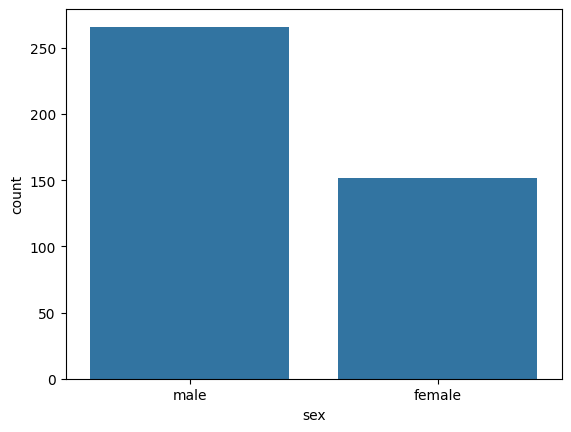

In [90]:
# distribution for sex

plot_distribution(final_df,'sex')

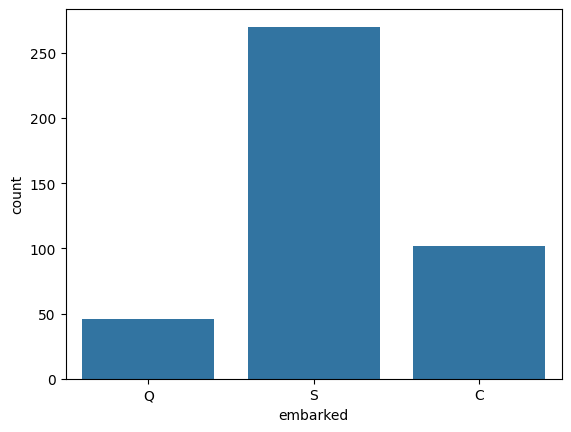

In [91]:
# distribution for embarked 

plot_distribution(final_df,'embarked')

# Feature_Eng

In [92]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,34.5,7.8292,Q,0
1,1,3,female,47.0,7.0000,S,1
2,0,2,male,62.0,9.6875,Q,0
3,0,3,male,27.0,8.6625,S,0
4,1,3,female,22.0,12.2875,S,2


In [93]:
# make X and y

X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [94]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,34.5,7.8292,Q,0
1,3,female,47.0,7.0000,S,1
2,2,male,62.0,9.6875,Q,0
3,3,male,27.0,8.6625,S,0
4,3,female,22.0,12.2875,S,2


In [95]:
# do train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print('The shape of training data is',X_train.shape)
print('The shape of testing data is',X_test.shape)

The shape of training data is (334, 6)
The shape of testing data is (84, 6)


## Pipelines for Individual Columns

In [96]:
# age_pipeline
age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)),
    ('scale',StandardScaler())
])


age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [97]:
# fare pipeline

fare_pipe = Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('scale',StandardScaler())
])

fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [98]:
# embarked_pipeline

embarked_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('count_encode',CountFrequencyEncoder(encoding_method='count')),
    ('scale',MinMaxScaler())
])

embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

## Column Transformer

In [99]:
set_config(transform_output='pandas')

In [100]:
# make column column transformer

preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked',embarked_pipe,['embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['sex']),
    ('family',MinMaxScaler(),['family'])
],remainder='passthrough',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [101]:
# fit and transform the training data

preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
336,0.145210,-0.557439,1.00,0.0,1.0,0.0,2
31,-0.475564,0.261686,1.00,0.0,1.0,0.2,2
84,0.011168,-0.658909,0.00,0.0,1.0,0.0,2
287,-0.475564,1.941029,1.00,0.0,1.0,0.1,1
317,-0.863547,-0.668132,1.00,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...
71,-0.708354,-0.783438,1.00,0.0,1.0,0.0,3
106,-0.708354,-0.786759,0.00,0.0,1.0,0.0,3
270,1.231563,1.941029,0.25,0.0,1.0,0.0,1
348,-0.475564,-0.535301,1.00,0.0,1.0,0.0,2


In [102]:
preprocessor.get_params()

{'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
 'fare':

# Model Pipeline

In [103]:
# build the model pipeline

model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [104]:
model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('clf',RandomForestClassifier())
])

model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf', RandomForestClassifier())])

# MLFlow Tracking code

## Grid Search

In [105]:
# set the uri for server

mlflow.set_tracking_uri("http://127.0.0.1:8080")

mlflow.set_experiment("Grid Search")

mlflow.sklearn.autolog()

params_grid = {
    "clf__n_estimators": list(range(100,300,100)),
    "clf__max_depth": [2,3,4,5,6,7]
}

with mlflow.start_run(run_name='outer',nested=True) as parent:
    # grid search object
    grid_search = GridSearchCV(estimator=model_pipe,
                               cv=3,
                               param_grid=params_grid,
                               scoring='accuracy',
                               n_jobs=-1)
    # fit the grid search
    grid_search.fit(X_train,y_train)

with mlflow.start_run(run_name='best_model') as best:
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("best_accuracy",grid_search.best_score_)
    mlflow.sklearn.log_model(sk_model=grid_search.best_estimator_,
                            artifact_path='best_model',
                            registered_model_name='Titanic_Random_Forest')


2024/09/22 19:13:18 INFO mlflow.tracking.fluent: Experiment with name 'Grid Search' does not exist. Creating a new experiment.
2024/09/22 19:13:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more deta

## Hyperopt

In [107]:
!pip install hyperopt

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tk-0.1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.6 MB/s eta 0:00:00a 0:00:01


In [108]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [109]:
# define the search space

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'criterion': hp.choice('criterion',['gini','entropy'])
}

In [122]:
def objective(params):
    with mlflow.start_run(nested=True):
        # log the params
        mlflow.log_params(params)
        n_estimators = int(params['n_estimators'])
        max_depth = int(params['max_depth'])
        # model object
        model_pipe.named_steps['clf'].set_params(**{'n_estimators':n_estimators,'max_depth':max_depth})
        # model fit
        model_pipe.fit(X_train,y_train)
        # calculate predictions
        y_pred = model_pipe.predict(X_test)
        # calculate accuracy
        accuracy = accuracy_score(y_test,y_pred)
        mlflow.log_metric("accuracy",accuracy)

    return {"loss":-accuracy,"status":STATUS_OK}

In [119]:
# # Set the tracking URI and experiment
# mlflow.set_tracking_uri("http://127.0.0.1:8080")
# mlflow.set_experiment("HP Tuning Hyperopt")

# # Enable autologging
# mlflow.sklearn.autolog() 

# # Define the parameter grid
# params_grid = {
#     "clf__n_estimators": list(range(100, 400, 100)), 
#     "clf__max_depth": [2, 3, 4, 5]
# }

# # Start the outer run for grid search
# with mlflow.start_run(run_name='outer', nested=True) as parent:
#     grid_search = GridSearchCV(estimator=model_pipe, 
#                                cv=3, 
#                                param_grid=params_grid, 
#                                scoring='accuracy',
#                                n_jobs=-1)
#     # Fit the grid search
#     grid_search.fit(X_train, y_train)

# # Start a new run to log the best model
# with mlflow.start_run(run_name='best_model') as best: 
#     mlflow.log_params(grid_search.best_params_)
#     mlflow.log_metric("best_accuracy", grid_search.best_score_)  # Log the best score
#     mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path= 'best_model')  
# # Log the best model


In [ ]:
mlflow.set_tracking_uri)"http://"

In [121]:
import mlflow
logged_model = 'runs:/370376ed45294b1b876cf49b44109628/model.pkl'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_test))

In [123]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

mlflow.set_experiment("HP Tuning Hyperopt")

with mlflow.start_run(nested=True): 
    trials = Trials()

    best = fmin(fn=objective,
               space=space, 
               algo=tpe.suggest, 
               max_evals=50, 
               trials = trials)

  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

2024/09/22 23:26:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

  2%|▍                       | 1/50 [00:04<03:52,  4.74s/trial, best loss: -1.0]

2024/09/22 23:26:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

  4%|▉                       | 2/50 [00:07<02:38,  3.30s/trial, best loss: -1.0]

2024/09/22 23:26:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

  6%|█▍                      | 3/50 [00:09<02:08,  2.74s/trial, best loss: -1.0]

2024/09/22 23:26:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

  8%|█▉                      | 4/50 [00:11<01:58,  2.59s/trial, best loss: -1.0]

2024/09/22 23:26:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 10%|██▍                     | 5/50 [00:13<01:53,  2.52s/trial, best loss: -1.0]

2024/09/22 23:26:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 12%|██▉                     | 6/50 [00:16<01:46,  2.42s/trial, best loss: -1.0]

2024/09/22 23:26:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 14%|███▎                    | 7/50 [00:18<01:39,  2.31s/trial, best loss: -1.0]

2024/09/22 23:26:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 16%|███▊                    | 8/50 [00:20<01:35,  2.28s/trial, best loss: -1.0]

2024/09/22 23:26:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 18%|████▎                   | 9/50 [00:22<01:31,  2.22s/trial, best loss: -1.0]

2024/09/22 23:26:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 20%|████▌                  | 10/50 [00:24<01:28,  2.22s/trial, best loss: -1.0]

2024/09/22 23:26:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 22%|█████                  | 11/50 [00:26<01:26,  2.22s/trial, best loss: -1.0]

2024/09/22 23:26:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 24%|█████▌                 | 12/50 [00:29<01:25,  2.24s/trial, best loss: -1.0]

2024/09/22 23:26:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 26%|█████▉                 | 13/50 [00:31<01:22,  2.22s/trial, best loss: -1.0]

2024/09/22 23:26:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:26:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 28%|██████▍                | 14/50 [00:33<01:19,  2.20s/trial, best loss: -1.0]

2024/09/22 23:27:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 30%|██████▉                | 15/50 [00:35<01:15,  2.16s/trial, best loss: -1.0]

2024/09/22 23:27:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 32%|███████▎               | 16/50 [00:37<01:14,  2.19s/trial, best loss: -1.0]

2024/09/22 23:27:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 34%|███████▊               | 17/50 [00:40<01:11,  2.18s/trial, best loss: -1.0]

2024/09/22 23:27:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 36%|████████▎              | 18/50 [00:42<01:10,  2.20s/trial, best loss: -1.0]

2024/09/22 23:27:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 38%|████████▋              | 19/50 [00:44<01:08,  2.21s/trial, best loss: -1.0]

2024/09/22 23:27:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 40%|█████████▏             | 20/50 [00:46<01:06,  2.21s/trial, best loss: -1.0]

2024/09/22 23:27:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 42%|█████████▋             | 21/50 [00:48<01:03,  2.18s/trial, best loss: -1.0]

2024/09/22 23:27:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 44%|██████████             | 22/50 [00:50<01:01,  2.18s/trial, best loss: -1.0]

2024/09/22 23:27:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 46%|██████████▌            | 23/50 [00:53<00:59,  2.19s/trial, best loss: -1.0]

2024/09/22 23:27:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 48%|███████████            | 24/50 [00:55<00:58,  2.26s/trial, best loss: -1.0]

2024/09/22 23:27:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 50%|███████████▌           | 25/50 [00:57<00:56,  2.26s/trial, best loss: -1.0]

2024/09/22 23:27:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 52%|███████████▉           | 26/50 [01:00<00:53,  2.24s/trial, best loss: -1.0]

2024/09/22 23:27:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 54%|████████████▍          | 27/50 [01:02<00:50,  2.20s/trial, best loss: -1.0]

2024/09/22 23:27:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 56%|████████████▉          | 28/50 [01:04<00:48,  2.20s/trial, best loss: -1.0]

2024/09/22 23:27:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 58%|█████████████▎         | 29/50 [01:06<00:45,  2.19s/trial, best loss: -1.0]

2024/09/22 23:27:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 60%|█████████████▊         | 30/50 [01:08<00:43,  2.18s/trial, best loss: -1.0]

2024/09/22 23:27:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 62%|██████████████▎        | 31/50 [01:10<00:42,  2.21s/trial, best loss: -1.0]

2024/09/22 23:27:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 64%|██████████████▋        | 32/50 [01:13<00:41,  2.28s/trial, best loss: -1.0]

2024/09/22 23:27:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 66%|███████████████▏       | 33/50 [01:15<00:38,  2.27s/trial, best loss: -1.0]

2024/09/22 23:27:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 68%|███████████████▋       | 34/50 [01:17<00:36,  2.26s/trial, best loss: -1.0]

2024/09/22 23:27:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 70%|████████████████       | 35/50 [01:20<00:33,  2.23s/trial, best loss: -1.0]

2024/09/22 23:27:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 72%|████████████████▌      | 36/50 [01:22<00:30,  2.19s/trial, best loss: -1.0]

2024/09/22 23:27:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 74%|█████████████████      | 37/50 [01:24<00:28,  2.16s/trial, best loss: -1.0]

2024/09/22 23:27:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 76%|█████████████████▍     | 38/50 [01:26<00:25,  2.13s/trial, best loss: -1.0]

2024/09/22 23:27:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 78%|█████████████████▉     | 39/50 [01:28<00:24,  2.23s/trial, best loss: -1.0]

2024/09/22 23:27:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 80%|██████████████████▍    | 40/50 [01:31<00:22,  2.23s/trial, best loss: -1.0]

2024/09/22 23:27:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:27:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 82%|██████████████████▊    | 41/50 [01:33<00:19,  2.20s/trial, best loss: -1.0]

2024/09/22 23:28:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 84%|███████████████████▎   | 42/50 [01:35<00:17,  2.19s/trial, best loss: -1.0]

2024/09/22 23:28:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 86%|███████████████████▊   | 43/50 [01:37<00:15,  2.18s/trial, best loss: -1.0]

2024/09/22 23:28:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 88%|████████████████████▏  | 44/50 [01:39<00:13,  2.18s/trial, best loss: -1.0]

2024/09/22 23:28:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 90%|████████████████████▋  | 45/50 [01:41<00:10,  2.19s/trial, best loss: -1.0]

2024/09/22 23:28:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 92%|█████████████████████▏ | 46/50 [01:44<00:09,  2.29s/trial, best loss: -1.0]

2024/09/22 23:28:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 94%|█████████████████████▌ | 47/50 [01:46<00:06,  2.25s/trial, best loss: -1.0]

2024/09/22 23:28:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 96%|██████████████████████ | 48/50 [01:48<00:04,  2.21s/trial, best loss: -1.0]

2024/09/22 23:28:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

 98%|██████████████████████▌| 49/50 [01:50<00:02,  2.17s/trial, best loss: -1.0]

2024/09/22 23:28:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/09/22 23:28:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Framewor

100%|███████████████████████| 50/50 [01:52<00:00,  2.26s/trial, best loss: -1.0]

2024/09/22 23:28:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-fawn-848 at: http://127.0.0.1:8080/#/experiments/624558978551097049/runs/a2dfe306a450406cbddbe3adf43a81b6.
2024/09/22 23:28:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/624558978551097049.
